<a href="https://colab.research.google.com/github/LeroyMichael/Big_Data_Processing/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when 
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from matplotlib import  pyplot as plt

In [ ]:
spark = SparkSession.builder.getOrCreate() 

In [ ]:
df_train = spark.read.csv("/content/drive/My Drive/Clustering/BearTraining.csv", inferSchema=True,header=True)
df_train = df_train.select("Ear Shape","Front Claws","Pupillary Distance")
df_train = df_train.na.drop()

In [ ]:
df_train = df_train.withColumn("Ear Shape",when(df_train["Ear Shape"] == "Rounded",2).
when(df_train["Ear Shape"] == "Broad",1).when(df_train["Ear Shape"] == "Pointed",0))

In [ ]:
cols = df_train.columns
df_train = VectorAssembler(inputCols=cols,outputCol="features").transform(df_train)

In [ ]:
scaler = StandardScaler(inputCol="features",outputCol="scaled")
df_train = scaler.fit(df_train).transform(df_train)

In [ ]:
df_test = spark.read.csv("/content/drive/My Drive/Clustering/BearTesting.csv", inferSchema=True,header=True)
df_test = df_test.select("Ear Shape","Front Claws","Pupillary Distance","Grizzly")
df_test = df_test.na.drop()

In [ ]:
df_test = df_test.withColumn("Ear Shape",when(df_test["Ear Shape"] == "Rounded",2).
when(df_test["Ear Shape"] == "Broad",1).when(df_test["Ear Shape"] == "Pointed",0))
df_test = df_test.withColumn("Grizzly",when(df_test["Grizzly"] == "Yes",1).otherwise(0))
df_test = df_test.na.drop()

In [ ]:
cols = df_test.columns
cols.remove("Grizzly")
df_test = VectorAssembler(inputCols=cols,outputCol="features").transform(df_test)


In [ ]:
scaler = StandardScaler(inputCol="features",outputCol="scaled")
df_test = scaler.fit(df_test).transform(df_test)

In [ ]:
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(df_train)

In [ ]:
prediction = model.transform(df_test)


In [ ]:
prediction = prediction.toPandas()

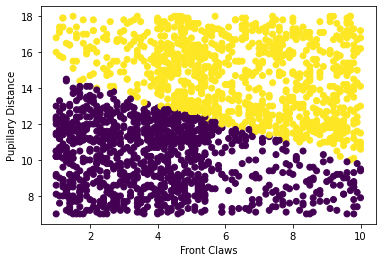

In [ ]:
figure = plt.figure()
ax = figure.add_subplot(111)
plt.scatter(prediction["Front Claws"], prediction["Pupillary Distance"],c=prediction["prediction"])
ax.set_xlabel("Front Claws")
ax.set_ylabel("Pupillary Distance")
plt.show()

In [ ]:
c=0
for index, row in prediction.iterrows():
  if row["Grizzly"] == row["prediction"]:
      c +=1
print("Accuracy : {}%".format(c/len(prediction)*100))

Accuracy : 77.2%
